# **Clasificación de tweets misóginos y no misóginos**

**Equipo:**

Fernando Barajas Ramírez 2085375​

Leobardo García Reyes 1616825

David Eduardo Gallardo Fernández 0931556

# Librerías

In [380]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [381]:
!pip install geopandas
!pip install vaderSentiment
!pip install pygal_maps_world

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
import pygal

from time import time
import re, string, unicodedata
from unicodedata import normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

import sklearn
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score

In [383]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

# Lectura y manipulación de la base de datos

In [384]:
# Lectura de base de datos
base = pd.read_csv('/content/drive/MyDrive/Mini-proyecto Texto/tweets_mnm.csv')
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1206924075374956547,Las feminazis quieren por poco que este chico ...,2019-12-17 13:08:17,Argentina,1683,2710,28982,El Progresismo es un Cáncer que quiere destrui...,False,es,misogino
1,1210912199402819584,@CarlosVerareal @Galois2807 Los halagos con pi...,2019-12-28 13:15:40,Ecuador,398,1668,3123,Cuando te encuentres n una situación imposible...,False,es,misogino
2,1210643148998938625,@drummniatico No se vaya asustar! Ese es el gr...,2019-12-27 19:26:34,Samborondon - Ecuador,1901,1432,39507,Todo se alinea a nuestro favor. 💙💙💙💙,False,es,misogino
3,1210643148998938625,@drummniatico No se vaya asustar! Ese es el gr...,2019-12-27 19:26:34,Samborondon - Ecuador,1901,1432,39507,Todo se alinea a nuestro favor. 💙💙💙💙,False,es,misogino


In [385]:
# Información de las variables
base.dtypes

ID                      int64
Tweet                  object
Creado_tweet           object
Locacion_usuario       object
Seguidores_usuario      int64
Amigos_usuario          int64
Favoritos_usuario       int64
Descripcion_usuario    object
Verificado_usuario       bool
Idioma                 object
Tipo                   object
dtype: object

In [386]:
# Conteo de tipos de tweets
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       5375
no_misogino    4869
Name: Tipo, dtype: int64

In [387]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(base.shape))
print('\n')
print(base.columns)

Dimensiones: (10244, 11)


Index(['ID', 'Tweet', 'Creado_tweet', 'Locacion_usuario', 'Seguidores_usuario',
       'Amigos_usuario', 'Favoritos_usuario', 'Descripcion_usuario',
       'Verificado_usuario', 'Idioma', 'Tipo'],
      dtype='object')


In [388]:
# Quitar IDs duplicados
base = base.drop_duplicates(base.columns[~base.columns.isin(['ID'])],
                                keep = 'first')
base = base.reset_index(drop=True)

In [389]:
# Filtrar solo los tweets en Idioma "es"
base = base[(base.Idioma == "es")]

In [390]:
base = base.sample(frac = 1).reset_index(drop = True)
base.head(4)

,ID,Tweet,Creado_tweet,Locacion_usuario,Seguidores_usuario,Amigos_usuario,Favoritos_usuario,Descripcion_usuario,Verificado_usuario,Idioma,Tipo
0,1210562542214483968,@InesArrimadas @CiudadanosCs Eres un poco estú...,2019-12-27 14:06:15,NaN,5,14,510,elmio,False,es,misogino
1,1203032865602228226,Hay que ser muy hijo de puta para criticar a G...,2019-12-06 19:26:01,"Orillas Río Eurolarva, Murcia",2328,679,34355,"Perdón, por si acaso. Escribo cosas en @altern...",False,es,no_misogino
2,1204469577448472576,Así respondió Greta Thunberg a insulto de Bols...,2019-12-10 18:34:59,"Colombia, Bogotá",18096,7594,9,Radio Santa Fe 1070 am. La radio Independiente...,False,es,no_misogino
3,1205108471055765505,"""estúpida"", ""histérica"" ""puta"" y ""majareta"" so...",2019-12-12 12:53:43,Europe,11008,2175,12118,Italian in Madrid. Data journalist at @el_pais...,True,es,no_misogino


In [391]:
# Formato a la columna de Creado_tweet
base['Creado_tweet'] = pd.to_datetime(base['Creado_tweet'], format='%Y-%m-%d')

In [392]:
# Agregar columna Verificado para saber si un usuario es verificado o no
base['Verificado'] = base['Verificado_usuario'].apply(lambda x: 'Si' if x==True else 'No')

In [393]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(base.shape))
print('\n')
print(base.columns)

Dimensiones: (7418, 12)


Index(['ID', 'Tweet', 'Creado_tweet', 'Locacion_usuario', 'Seguidores_usuario',
       'Amigos_usuario', 'Favoritos_usuario', 'Descripcion_usuario',
       'Verificado_usuario', 'Idioma', 'Tipo', 'Verificado'],
      dtype='object')


In [394]:
# Conteo final por tipo de tweet
base.groupby(['Tipo'])['Tipo'].count()

Tipo
misogino       3661
no_misogino    3757
Name: Tipo, dtype: int64

# Limpieza de texto

In [395]:
# Selección de la columna que contine los tweets y la columna de tipo del tweet al que pertenece
TText = pd.DataFrame({'Texto': base['Tweet'], 'Tipo': base['Tipo']})
TText.head(3)

,Texto,Tipo
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino
2,Así respondió Greta Thunberg a insulto de Bols...,no_misogino


In [396]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de usuarios
    nuevo_texto = re.sub('@[\w\-]+', ' ', nuevo_texto)

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', ' ', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de acentos
    #nuevo_texto = re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1',
    #                     normalize('NFD', nuevo_texto), 0, re.I)
    a,b = 'áéíóúÁÉÍÓÚ','aeiouAEIOU'
    trans = str.maketrans(a,b)
    nuevo_texto = nuevo_texto.translate(trans)
    
    # Eliminación de emojis
    emoj = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002500-\U00002BEF'  # chinese char
        u'\U00002702-\U000027B0'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U0001f926-\U0001f937'
        u'\U00010000-\U0010ffff'
        u'\u2640-\u2642' 
        u'\u2600-\u2B55'
        u'\u200d'
        u'\u23cf'
        u'\u23e9'
        u'\u231a'
        u'\ufe0f'  # dingbats
        u'\u3030'
                      ']+', re.UNICODE)
    nuevo_texto = re.sub(emoj, ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [397]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['Texto_Limpio'] = TText['Texto'].apply(lambda x: Limpiar_texto(x))
TText[['Texto', 'Tipo', 'Texto_Limpio']].head(3)

,Texto,Tipo,Texto_Limpio
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,eres un poco estupida no sanchez cada vez tie...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hay que ser muy hijo de puta para criticar a g...
2,Así respondió Greta Thunberg a insulto de Bols...,no_misogino,asi respondio greta thunberg a insulto de bols...


## Stopwords

In [430]:
# Stopwords en español
sw = stopwords.words('spanish')

# Nuevas stopwords
nuevas_sw = ['años', 'si', 'va', 'así', 'ver', 'vez', 'ser', 'do', 'dice', 'hace', 'toda', 'pues', 'da', 'mas',
             'tan', 'hacer', 'decir', 'an', 'ma', 'asi', 'da', 'año', 'años', 'año', 'años', 'estan', 'va',
             'mas', 'cada', 'os', 'ensen', 'ar', 'espan', 'puede', 'nin', 'sen', 'pue', 'ja', 'jajaja', 'demas']

sw.extend(nuevas_sw)

print(sw)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [431]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['Texto_Pos'] = TText['Texto_Limpio'].apply(token_stop_pos)
TText.head(3)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,eres un poco estupida no sanchez cada vez tie...,"[(estupida, a), (sanchez, n), (votantes, v), (...",estupida sanchez votantes pensamientos actos...,"[estupida, sanchez, votantes, pensamientos, ac...",estupida sanchez votantes pensamientos actos...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hay que ser muy hijo de puta para criticar a g...,"[(hijo, n), (puta, None), (criticar, n), (gret...",hijo puta criticar greta thunberg pienses de...,"[hijo, puta, criticar, greta, thunberg, piense...",hijo puta criticar greta thunberg pienses de...
2,Así respondió Greta Thunberg a insulto de Bols...,no_misogino,asi respondio greta thunberg a insulto de bols...,"[(respondio, n), (greta, n), (thunberg, v), (i...",respondio greta thunberg insulto bolsonaro d...,"[respondio, greta, thunberg, insulto, bolsonar...",respondio greta thunberg insulto bolsonaro d...


## Lematización

In [432]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['Lema'] = TText['Texto_Pos'].apply(lemmatize)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,eres un poco estupida no sanchez cada vez tie...,"[(estupida, a), (sanchez, n), (votantes, v), (...",estupida sanchez votantes pensamientos actos...,"[estupida, sanchez, votantes, pensamientos, ac...",estupida sanchez votantes pensamientos actos...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hay que ser muy hijo de puta para criticar a g...,"[(hijo, n), (puta, None), (criticar, n), (gret...",hijo puta criticar greta thunberg pienses de...,"[hijo, puta, criticar, greta, thunberg, piense...",hijo puta criticar greta thunberg pienses de...


## Selección de palabras mayores a 1 carácter

In [433]:
# Función para elegir las palabras mayores a 1 carácter
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['Mayores'] = TText['Lema'].apply(mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,eres un poco estupida no sanchez cada vez tie...,"[(estupida, a), (sanchez, n), (votantes, v), (...",estupida sanchez votantes pensamientos actos...,"[estupida, sanchez, votantes, pensamientos, ac...",estupida sanchez votantes pensamientos actos...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hay que ser muy hijo de puta para criticar a g...,"[(hijo, n), (puta, None), (criticar, n), (gret...",hijo puta criticar greta thunberg pienses de...,"[hijo, puta, criticar, greta, thunberg, piense...",hijo puta criticar greta thunberg pienses de...


In [434]:
# Función para juntar cada tweet en un solo texto
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['Lema_Mayores'] = TText['Mayores'].apply(lema_mayores)
TText.head(2)

,Texto,Tipo,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,eres un poco estupida no sanchez cada vez tie...,"[(estupida, a), (sanchez, n), (votantes, v), (...",estupida sanchez votantes pensamientos actos...,"[estupida, sanchez, votantes, pensamientos, ac...",estupida sanchez votantes pensamientos actos...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hay que ser muy hijo de puta para criticar a g...,"[(hijo, n), (puta, None), (criticar, n), (gret...",hijo puta criticar greta thunberg pienses de...,"[hijo, puta, criticar, greta, thunberg, piense...",hijo puta criticar greta thunberg pienses de...


In [435]:
# Selección de la columna que contiene los tweets originales, la columna del tipo de tweet
# al que pertenece y la columna con los tweets limpios
Texto_final = TText.loc[:, ['Texto', 'Tipo', 'Lema_Mayores']]
Texto_final.head(2)

,Texto,Tipo,Lema_Mayores
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,estupida sanchez votantes pensamientos actos...
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hijo puta criticar greta thunberg pienses de...


In [436]:
# Codificar el tipo de tweet, donde no_misogino sea 0 y misogino sea 1 
#Texto_final['Categoria_ID'] = Texto_final['Tipo'].factorize()[0]
Texto_final['Categoria_ID'] = Texto_final['Tipo'].apply(lambda x: 1 if x=='misogino' else 0)
Categoria_ID_datos = Texto_final[['Tipo', 'Categoria_ID']].drop_duplicates().sort_values('Categoria_ID')
Categoria_a_ID = dict(Categoria_ID_datos.values)
ID_a_Categoria = dict(Categoria_ID_datos[['Categoria_ID', 'Tipo']].values)
Texto_final.head(3)

,Texto,Tipo,Lema_Mayores,Categoria_ID
0,@InesArrimadas @CiudadanosCs Eres un poco estú...,misogino,estupida sanchez votantes pensamientos actos...,1
1,Hay que ser muy hijo de puta para criticar a G...,no_misogino,hijo puta criticar greta thunberg pienses de...,0
2,Así respondió Greta Thunberg a insulto de Bols...,no_misogino,respondio greta thunberg insulto bolsonaro d...,0


# Gráficos

In [437]:
# Conteo final por tipo de tweet
Tabla_Conteo = base['Tipo'].value_counts()
Tabla_Conteo

no_misogino    3757
misogino       3661
Name: Tipo, dtype: int64

In [438]:
# Conteo por tipo de tweet y si un usuario es verificado
base.groupby(['Tipo','Verificado']).count()

ID  Tweet  Creado_tweet  Locacion_usuario  \
Tipo        Verificado                                                
misogino    No          3655   3655          3655              2629   
            Si             6      6             6                 5   
no_misogino No          3181   3181          3181              2213   
            Si           576    576           576               445   

                        Seguidores_usuario  Amigos_usuario  Favoritos_usuario  \
Tipo        Verificado                                                          
misogino    No                        3655            3655               3655   
            Si                           6               6                  6   
no_misogino No                        3181            3181               3181   
            Si                         576             576                576   

                        Descripcion_usuario  Verificado_usuario  Idioma  
Tipo        Verificado                                                   
misogino    No                         3048                3655    3655  
            Si                            6                   6       6  
no_misogino No                         2761                3181    3181  
            Si                          573                 576     576

In [439]:
# Conteo de ID por tipo de tweet y si un usuario es verificado
conteo = base.groupby(['Tipo','Verificado'])['ID'].count()
conteo

Tipo         Verificado
misogino     No            3655
             Si               6
no_misogino  No            3181
             Si             576
Name: ID, dtype: int64

## Gráfica de pastel

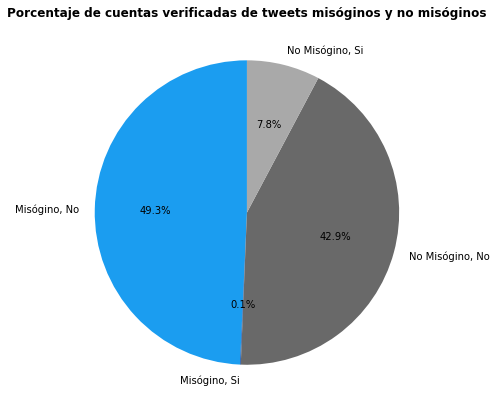

In [440]:
#color = ['purple', 'darkorchid', 'dimgray', 'darkgray']
color = ['#1b9df0', '#004aad', 'dimgray', 'darkgray']
labels = 'Misógino, No', 'Misógino, Si', 'No Misógino, No', 'No Misógino, Si'
conteopastel = base.groupby(['Tipo','Verificado'])['ID'].count()

plt.figure(figsize = (10, 7))
plt.pie(conteopastel, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = color)
plt.title('Porcentaje de cuentas verificadas de tweets misóginos y no misóginos', fontweight = 'bold')
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/pastel.jpg')

## Gráfica de barras

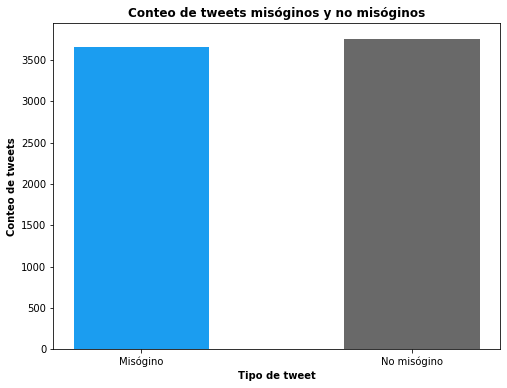

In [441]:
color = ['#1b9df0', 'dimgray']
etiqueta = ['Misógino', 'No misógino']
conteobarra = Texto_final.groupby('Tipo').Lema_Mayores.count()

fig = plt.figure(figsize = (8,6))
plt.bar(etiqueta, conteobarra, color = color,width = 0.5)
plt.title('Conteo de tweets misóginos y no misóginos', fontweight = 'bold')
plt.xlabel('Tipo de tweet', fontweight = 'bold')
plt.ylabel('Conteo de tweets', fontweight = 'bold')
#plt.show()
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/barras.jpg')

## Gráfica de tiempo de los tweets

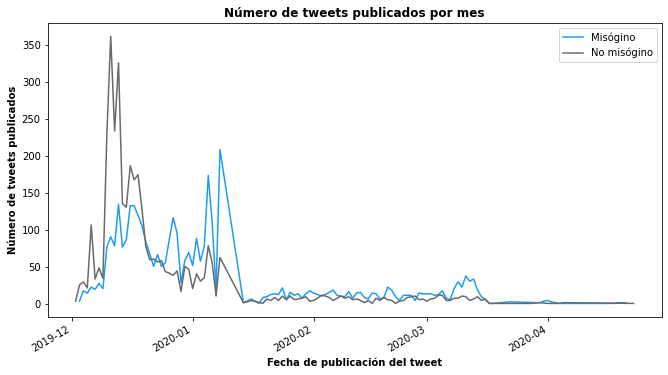

In [442]:
fig, ax = plt.subplots(figsize=(11,6))

for Tipo in base.Tipo.unique():
    df_temp = base[base['Tipo'] == Tipo].copy()
    df_temp['Creado_tweet'] = pd.to_datetime(df_temp['Creado_tweet'].dt.strftime('%Y-%m-%d'))
    df_temp = df_temp.groupby(df_temp['Creado_tweet']).size()
    df_temp.plot(label=Tipo, ax=ax, color={"misogino": '#1b9df0', "no_misogino": 'dimgray'})

plt.title('Número de tweets publicados por mes', fontweight = 'bold')
plt.xlabel('Fecha de publicación del tweet', fontweight = 'bold')
plt.ylabel('Número de tweets publicados', fontweight = 'bold')
ax.legend(['Misógino', 'No misógino'])
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/serie.jpg')

## Nube de palabras

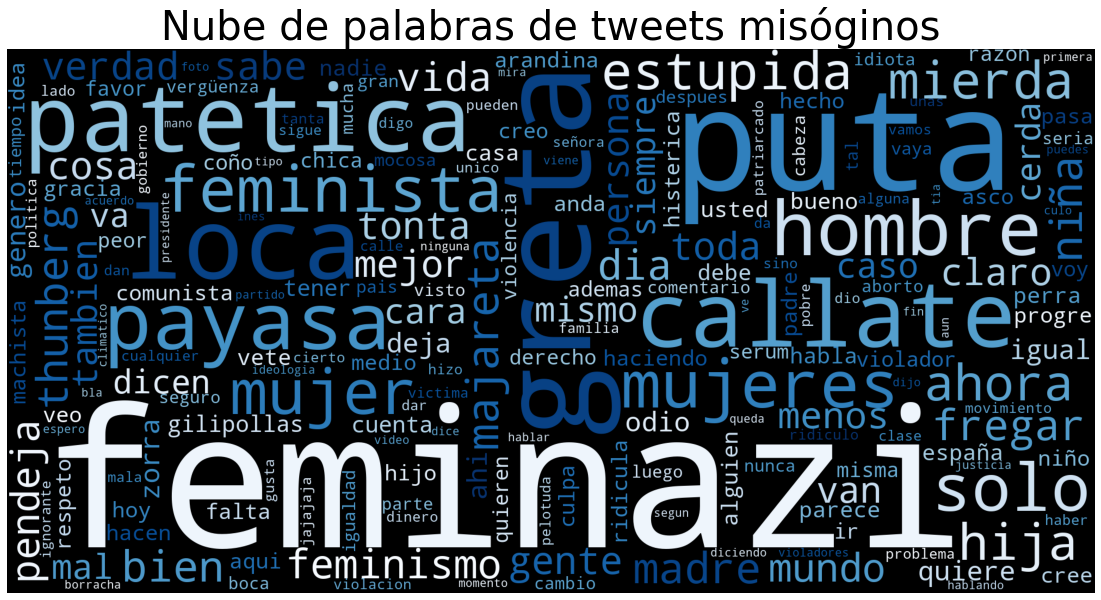

In [443]:
# Generar nube de palabras
# Greys
# RdPu
# Texto_final['Lema_Mayores']
# Texto_final[Texto_final['Tipo']=='misogino'] o 'no_misogino'
metodo = Texto_final[Texto_final['Tipo'] == 'misogino']
plt.figure(figsize = (20,10))
text_nube = metodo.Lema_Mayores.values
cloud1 = WordCloud(background_color = 'black', colormap = 'Blues', collocations = False,
                 width = 2000, height = 1000).generate(' '.join(text_nube))

plt.axis('off')
plt.title('Nube de palabras de tweets misóginos', fontsize = 40)
plt.imshow(cloud1)
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/nube1.jpg')

## Frecuencia de palabras

In [444]:
texto_analizar = metodo['Lema_Mayores']
tokenizar = [cadena.split() for cadena in texto_analizar]
descripcion = []
for cadena in tokenizar:
    for i in cadena:
        descripcion.append(i)

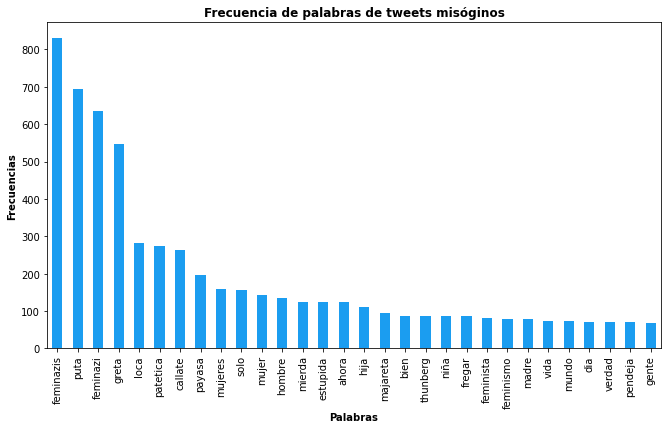

In [445]:
# drimgray
# #1b9df0
def gra_pa(datos, titulo = None):
    aux = pd.Series(datos)
    aux.value_counts()[:30].plot.bar(figsize = (11, 6), color = '#1b9df0')
    if titulo: 
        plt.title(titulo, fontweight = 'bold')
    plt.xlabel('Palabras', fontweight = 'bold')
    plt.ylabel('Frecuencias', fontweight = 'bold')

gra_pa(descripcion, titulo = 'Frecuencia de palabras de tweets misóginos')
plt.savefig('/content/drive/MyDrive/Mini-proyecto Texto/frecu1.jpg')

# Modelo

In [446]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', encoding = 'latin-1',
                        ngram_range = (1, 2), stop_words = sw)

features = tfidf.fit_transform(Texto_final.Lema_Mayores).toarray()
labels = Texto_final.Categoria_ID
features.shape

(7418, 3141)

In [447]:
N = 3
for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
  features_chi2 = chi2(features, labels == Categoria_ID)
  indices = np.argsort(features_chi2[Categoria_ID])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Tipo))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'misogino':
  . Most correlated unigrams:
       . voto
       . religion
       . silencio
  . Most correlated bigrams:
       . feminismo radical
       . libertad expresion
       . violencia mujer
# 'no_misogino':
  . Most correlated unigrams:
       . patetica
       . callate
       . feminazis
  . Most correlated bigrams:
       . greta majareta
       . greta thunberg
       . callate puta


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [448]:
X_train, X_test, y_train, y_test = train_test_split(Texto_final['Lema_Mayores'],
                                                    Texto_final['Tipo'], random_state = 0,
                                                    test_size = 0.35)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [449]:
# Entrenamiento de diferente modelos
Inicio = time()
models = [RandomForestClassifier(n_estimators = 200, max_depth = None, random_state = 0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state = 0)]

CV = 20
cv_df = pd.DataFrame(index = range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Final = time()
Tiempo_total = Final - Inicio

print("\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.".format(Tiempo_total // (60 * 60),
                                                                  Tiempo_total // 60,
                                                                  Tiempo_total % 60))


Tiempo de entrenamiento: 0h 14m 33s.


In [462]:
cv_df.to_csv('/content/drive/MyDrive/Mini-proyecto Texto/prueba.csv', header = True, index = False)

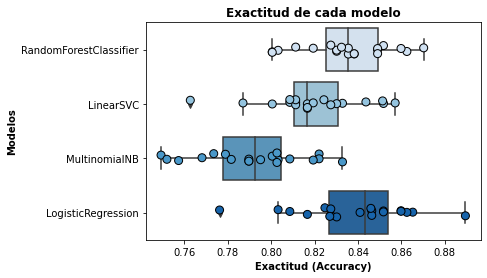

<Figure size 864x504 with 0 Axes>

In [460]:
# Gráfica de caja de todos los modelos
#, hue='model_name'
ax = sns.boxplot(x = 'accuracy', y = 'model_name', data = cv_df, palette = 'Blues')
sns.stripplot(x = 'accuracy', y = 'model_name', data = cv_df, palette = 'Blues',
              size=8, jitter=True, edgecolor = 'black', linewidth=1, dodge=True, ax=ax, ec='k')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[:4], labels[:4], title='Modelos', bbox_to_anchor=(1, 1.02),
#          loc='upper left')
plt.title('Exactitud de cada modelo', fontweight = 'bold')
plt.xlabel('Exactitud (Accuracy)', fontweight = 'bold')
plt.ylabel('Modelos', fontweight = 'bold')
plt.figure(figsize=(12, 7))
plt.show()

In [451]:
# Promedio de exactitud por modelo
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.819498
LogisticRegression        0.838096
MultinomialNB             0.791995
RandomForestClassifier    0.834731
Name: accuracy, dtype: float64

In [452]:
# Modelo seleccionado
model = LogisticRegression(random_state = 0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels,
                                                                                 Texto_final.index,
                                                                                 test_size = 0.35,
                                                                                 random_state = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Reporte

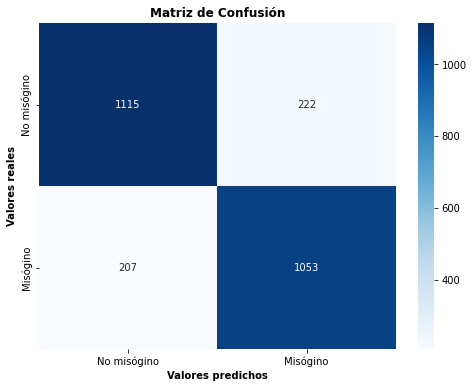

In [459]:
# Matriz de confusión
# PuBu
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(conf_mat, annot = True, fmt = 'd',
            xticklabels = ['No misógino', 'Misógino'],
            yticklabels = ['No misógino', 'Misógino'], cmap = 'Blues',
            linecolor = 'black')
plt.title('Matriz de Confusión', fontweight = 'bold')
plt.xlabel('Valores predichos', fontweight = 'bold')
plt.ylabel('Valores reales', fontweight = 'bold')
plt.show()

In [454]:
# Reporte de clasificación
Etiquetas = ['No misógino', 'Misógino']

print("Reporte de clasificación:")
print(metrics.classification_report(y_test, y_pred, target_names = Etiquetas))

Reporte de clasificación:
              precision    recall  f1-score   support

 No misógino       0.84      0.83      0.84      1337
    Misógino       0.83      0.84      0.83      1260

    accuracy                           0.83      2597
   macro avg       0.83      0.83      0.83      2597
weighted avg       0.83      0.83      0.83      2597



In [455]:
# Predicción de los tweets
for predicted in Categoria_ID_datos.Categoria_ID:
  for actual in Categoria_ID_datos.Categoria_ID:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(ID_a_Categoria[actual], ID_a_Categoria[predicted], conf_mat[actual, predicted]))
      display(Texto_final.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Tipo', 'Texto']])
      print('')

'misogino' predicted as 'no_misogino' : 207 examples.


,Tipo,Texto
4194,misogino,"Si Greta Thunberg fuera chilena, le dirían pen..."
5687,misogino,@cronicaansiosa Coye vale es que tu insulto se...
6786,misogino,"@umuball ... el violador eres tú! Y tu abuelo,..."
1022,misogino,"La Greta Thunberg vino en un Renfe Intercity, ..."
5398,misogino,"De hecho odiarlo está de moda, la palabra Femi..."
...,...,...
6920,misogino,@GretaThunberg Gilipollas
2661,misogino,@IrantzuVarela Doña vividora del conflicto sin...
3074,misogino,@edgardrebarati1's account is temporarily unav...
3410,misogino,La GRETA esta no tiene ni puta idea de nada. 1...



'no_misogino' predicted as 'misogino' : 222 examples.


,Tipo,Texto
39,no_misogino,"Greta no es ni histérica mi majareta, es solo ..."
3326,no_misogino,No puedo creer que haya tanta gente hija de pu...
1590,no_misogino,+ que a nosotras nos llevan llamando feminazis...
1551,no_misogino,Es de ambos y de dar y recibir. Esta gente ent...
1984,no_misogino,"@hijossinamparo Según algunos,la ley de violen..."
...,...,...
3789,no_misogino,"Independentistas, putos rojos, comunistas, ETA..."
2805,no_misogino,@PatricioJDiaz @DelfinSC Para que aprendas que...
117,no_misogino,@Luigielchinos @nicles980314 @Damdumont @Dalas...
2843,no_misogino,"Greta, vete a hacer los deberes https://t.co/K..."


In [456]:
# m
# nom
# m
# nom
# m
texts = ['Greta la majareta nunca ha visitado ni se ha quejado en los paises q más contaminan dl mundo, una marioneta d la extrema izquierda comunista.',
         'Entonces llega el momento en que todo fascista se convierte en hincha del Albacete, sigue todos los partidos de la Arandina y, sobre todo, es un entendido de Ópera, conocedor y admirador del vibrato de Plácido Domingo. De toda la vida. https://t.co/GqmQacy5k3',
         '@monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera.',
         'A mi lo de Greta me parece espectacular. ¿Qué es un monigote? Puede. ¿Qué es un producto de marketing? Quizás. ¿Qué está haciendo que todo el mundo hable de ecologismo por primera vez en la puta historia? Repito: todo el mundo. Totalmente sí.',
         'Respirar también contamina según Greta Thunberg me cago en su vida zorra https://t.co/4Cemt5BARQ']
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(ID_a_Categoria[predicted]))
  print("")

"Greta la majareta nunca ha visitado ni se ha quejado en los paises q más contaminan dl mundo, una marioneta d la extrema izquierda comunista."
  - Predicted as: 'misogino'

"Entonces llega el momento en que todo fascista se convierte en hincha del Albacete, sigue todos los partidos de la Arandina y, sobre todo, es un entendido de Ópera, conocedor y admirador del vibrato de Plácido Domingo. De toda la vida. https://t.co/GqmQacy5k3"
  - Predicted as: 'no_misogino'

"@monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera."
  - Predicted as: 'misogino'

"A mi lo de Greta me parece espectacular. ¿Qué es un monigote? Puede. ¿Qué es un producto de marketing? Quizás. ¿Qué está haciendo que todo el mundo hable de ecologismo por primera vez en la puta historia? Repito: todo el mundo. Totalmente sí."
  - Predicted as: 'no_misogino'

"Respirar también contamina según Greta Thunberg me cago en su vida zorra https://t.co/4Cemt5BARQ"
  - Predicted

In [457]:
#model.fit(features, labels)

#N = 3
#for Tipo, Categoria_ID in sorted(Categoria_a_ID.items()):
#  indices = np.argsort(model.coef_[Categoria_ID])
#  feature_names = np.array(tfidf.get_feature_names())[indices]
#  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
#  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#  print("# '{}':".format(Tipo))
#  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
#  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))